Import Necessary Libraries

In [8]:
import torch
from torch.optim import Adam, LBFGS
from torch.autograd import Variable
import numpy as np
import os
import argparse
import cv2 as cv
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.models as models
from collections import namedtuple
from matplotlib import pyplot as plt

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
device = torch.device("cuda") #Setting up the GPU
ImageNet_Means = [123.68,116.779,103.939] #to subtract these mean values from the corresponding RGB channel
ImageNet_STD = [1,1,1] #Std deviation used for normalizing, and we want no scaling to mainatain original range of pixel value

## Image Preprocessing Function

The `preprocess_img` function is designed for preprocessing images before using them in Neural Style Transfer (NST) or similar tasks. It performs the following steps:

1. **Read Image:**
   - Reads an image from the specified path and converts the color format from BGR to RGB.

2. **Resize Image:**
   - Resizes the image to the target shape while maintaining the aspect ratio. The target shape can be specified as a tuple `(height, width)` or a scalar value representing the new height.

3. **Normalize Image:**
   - Normalizes the image using mean and standard deviation values from ImageNet. This is a common practice in deep learning to align the data distribution with the pre-trained models.

4. **Device Placement:**
   - Transfers the preprocessed image to the specified device (default is CUDA if available).

### Parameters:
- `img_path`: Path to the input image.
- `target_shape`: Desired shape of the image after resizing. Can be a tuple `(height, width)` or a scalar value representing the new height.
- `device`: Device to which the preprocessed image is transferred (default is CUDA if available).

### Returns:
- A preprocessed image in the form of a PyTorch tensor.

In [11]:
def preprocess_img(img_path, target_shape, device = torch.device("cuda")):
  img = cv.imread(img_path)[:, :, ::-1] # converting BGR to RGB
  if type(target_shape) == tuple:
    img = cv.resize(img, (target_shape[1], target_shape[0]), interpolation=cv.INTER_CUBIC)
  else:
    current_height, current_width = img.shape[:2]
    new_height = target_shape
    ratio = new_height / current_height
    new_width = int(current_width * ratio)
    img = cv.resize(img, (new_width, new_height), interpolation=cv.INTER_CUBIC)

  # normalizing using ImageNet's mean
  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Lambda(lambda x: x.mul(255)),
      transforms.Normalize(mean=ImageNet_Means, std=ImageNet_STD)
  ])
  img = transform(img).to(device).unsqueeze(0)
  return img #-> torch.tensor

## Neural Style Transfer Feature Extraction

In Neural Style Transfer (NST), feature extraction plays a crucial role in blending the content of one image with the artistic style of another. The following Python code defines a `Vgg19` class, which extracts features from specific layers of the VGG19 network. These features are essential for capturing both the content and style representations required for generating stylized images.

This code snippet is part of the NST implementation and includes:

- Definition of the `Vgg19` class for feature extraction.
- Specification of layers for content and style representation.
- Slicing of the VGG19 network to obtain features from different layers.
- Freezing of model parameters when not optimizing model weights.

Let's explore the code in more detail:


In [12]:
class Vgg19(torch.nn.Module):
    """
    Used in the original NST paper, only those layers are exposed which were used in the original paper

    'conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1' were used for style representation
    'conv4_2' was used for content representation (although they did some experiments with conv2_2 and conv5_2)
    """
    def __init__(self, requires_grad=False, show_progress=False, use_relu=True):
        super().__init__()
        vgg_pretrained_features = models.vgg19(pretrained=True, progress=show_progress).features
        if use_relu:  # use relu or as in original paper conv layers
            self.layer_names = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'conv4_2', 'relu5_1']
            self.offset = 1
        else:
            self.layer_names = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv4_2', 'conv5_1']
            self.offset = 0
        self.content_feature_maps_index = 4  # conv4_2
        # all layers used for style representation except conv4_2
        self.style_feature_maps_indices = list(range(len(self.layer_names)))
        self.style_feature_maps_indices.remove(4)  # conv4_2

        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        self.slice5 = torch.nn.Sequential()
        self.slice6 = torch.nn.Sequential()
        for x in range(1+self.offset):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(1+self.offset, 6+self.offset):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(6+self.offset, 11+self.offset):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(11+self.offset, 20+self.offset):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        for x in range(20+self.offset, 22):
            self.slice5.add_module(str(x), vgg_pretrained_features[x])
        for x in range(22, 29++self.offset):
            self.slice6.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, x):
        x = self.slice1(x)
        layer1_1 = x
        x = self.slice2(x)
        layer2_1 = x
        x = self.slice3(x)
        layer3_1 = x
        x = self.slice4(x)
        layer4_1 = x
        x = self.slice5(x)
        conv4_2 = x
        x = self.slice6(x)
        layer5_1 = x
        vgg_outputs = namedtuple("VggOutputs", self.layer_names)
        out = vgg_outputs(layer1_1, layer2_1, layer3_1, layer4_1, conv4_2, layer5_1)
        return out

## Neural Style Transfer Model Preparation

The `prepare_model` function is designed for initializing and configuring neural style transfer models based on the specified architecture (`VGG19`). The function takes care of loading the pre-trained VGG model, setting its parameters, and extracting relevant information about content and style feature maps.

### Function Signature

```
def prepare_model(model, device):
    """
    Prepares a neural style transfer model.

    Parameters:
    - device (torch.device): The device (CPU or GPU) on which the model should be loaded, but default is GPU.

    Returns:
    - model (torch.nn.Module): The configured neural style transfer model.
    - content_fms_index_name (tuple): Tuple containing the content feature maps index and its corresponding layer name.
    - style_fms_indices_names (tuple): Tuple containing the style feature maps indices and their corresponding layer names.
    """
```
### Code Implementation ↓↓

In [13]:
def prepare_model( device = torch.device("cuda")):
  #Create an instance of the Vgg19 model
  model = Vgg19(requires_grad=False, show_progress=True)
  # Extract relevant information about content and style feature maps
  content_feature_maps_index = model.content_feature_maps_index
  style_feature_maps_indices = model.style_feature_maps_indices
  layer_names = model.layer_names
  # Create tuples with feature maps information
  content_fms_index_name = (content_feature_maps_index, layer_names[content_feature_maps_index])
  style_fms_indices_names = (style_feature_maps_indices, layer_names)
  # Move the model to the specified device, set to evaluation mode, and return
  return model.to(device).eval(), content_fms_index_name, style_fms_indices_names

## Neural Style Transfer Loss Functions

### Gram Matrix Calculation

The `gram_matrix` function is used to calculate the Gram matrix of a set of feature maps. Given a tensor $X$(in our case it is a feature maps of a particular layer in a VGG network) with dimensions $(b, ch, h, w)$, where $b$ is the batch size, $ch$ is the number of channels, and $h$ and $w$ are the height and width of the feature maps, the Gram matrix is computed as:

$\text{{Gram}}(X)_{ij} = \sum_k X_{ik} \cdot X_{jk}$

This operation captures the correlations between different channels and is crucial for style representation.

### Loss Function Calculation

The `Loss_Functions` function computes the total loss as a combination of content, style, and total variation losses. Let's break down each component:

#### Content Loss

The content loss measures the difference between the content representation of the generated image and the content representation of the target image. It is computed using the mean squared error (MSE) between their feature maps:

$\text{{Content Loss}}(P, F) = \frac{1}{2} \sum_{i,j}(P_{ij} - F_{ij})^2$

where $P$ is the target content representation, and $F$ is the current content representation.

#### Style Loss

The style loss quantifies the difference in style between the generated image and the style image. It is computed using the MSE between the Gram matrices of their feature maps:

$\text{{Style Loss}}(A, G) = \frac{1}{4 \cdot (N \cdot M)^2} \sum_{i,j}(A_{ij} - G_{ij})^2$

where $A$ is the target style representation, $G$ is the current style representation, $N$ is the number of channels, and $M$ is the height times the width of the feature maps.

#### Total Variation Loss

The total variation loss promotes spatial smoothness in the generated image. It is calculated as the sum of absolute differences between neighboring pixel values:

$\text{{TV Loss}}(I) = \sum_{i,j} \left( I_{i,j} - I_{i+1,j} \right)^2 + \left( I_{i,j} - I_{i,j+1} \right)^2$

where $I$ is the optimizing image.

#### Total Loss

The total loss is a weighted sum of the content, style, and total variation losses:

$
\text{{Total Loss}}(P, F, A, G, I) = \alpha \text{{Content Loss}}(P, F) + \beta \text{{Style Loss}}(A, G) + \gamma \text{{TV Loss}}(I)$

Here, $\alpha$, $\beta$, and $\gamma$ are hyperparameters controlling the influence of each loss component.

### Tuning Step

The `make_tuning_step` function returns a closure `tuning_step` that calculates the loss, backpropagates gradients, updates model parameters, and zeroes out gradients for a given optimizing image. This closure is used within the optimization loop to iteratively refine the generated image.

These loss functions and tuning steps are fundamental to the NST optimization process, guiding the generator to produce images that match the desired content and style characteristics.


In [14]:
def gram_matrix(x, should_normalize=True):
    (b, ch, h, w) = x.size()
    features = x.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t)
    if should_normalize:
        gram /= ch * h * w
    return gram

def Loss_Functions(neural_net, optimizing_img, target_representations, content_feature_maps_index, style_feature_maps_indices, config):
    target_content_representation = target_representations[0]
    target_style_representation = target_representations[1]

    current_set_of_feature_maps = neural_net(optimizing_img)

    current_content_representation = current_set_of_feature_maps[content_feature_maps_index].squeeze(axis=0)
    content_loss = torch.nn.MSELoss(reduction='mean')(target_content_representation, current_content_representation)

    style_loss = 0.0
    current_style_representation = [gram_matrix(x) for cnt, x in enumerate(current_set_of_feature_maps) if cnt in style_feature_maps_indices]
    for gram_gt, gram_hat in zip(target_style_representation, current_style_representation):
        style_loss += torch.nn.MSELoss(reduction='sum')(gram_gt[0], gram_hat[0])
    style_loss /= len(target_style_representation)

    tv_loss = torch.sum(torch.abs(optimizing_img[:, :, :, :-1] - optimizing_img[:, :, :, 1:])) + torch.sum(torch.abs(optimizing_img[:, :, :-1, :] - optimizing_img[:, :, 1:, :]))

    total_loss = config['content_weight'] * content_loss + config['style_weight'] * style_loss + config['tv_weight'] * tv_loss

    return total_loss, content_loss, style_loss, tv_loss

def make_tuning_step(neural_net, optimizer, target_representations, content_feature_maps_index, style_feature_maps_indices, config):
    def tuning_step(optimizing_img):
        # Calculate loss
        total_loss, content_loss, style_loss, tv_loss = build_loss(
            neural_net, optimizing_img, target_representations,
            content_feature_maps_index, style_feature_maps_indices, config
        )
        # Backpropagate gradients
        total_loss.backward()
        # Update model parameters
        optimizer.step()
        # Zero out gradients for the next iteration
        optimizer.zero_grad()
        return total_loss, content_loss, style_loss, tv_loss
    # Return the tuning step function
    return tuning_step


### Save the Image in the given dir

In [15]:
def save_image(optimizing_img, dump_path, config, cnt, num_of_iterations):
    out_img = optimizing_img.squeeze(axis=0).to('cpu').detach().numpy()
    out_img = np.moveaxis(out_img, 0, 2)  # swap channel from 1st to 3rd position: ch, _, _ -> _, _, chr
    img_format = config['img_format']
    # for saving_freq == -1 save only the final result (otherwise save with frequency saving_freq and save the last pic)
    if cnt == num_of_iterations - 1:
        out_img_name = str(cnt).zfill(img_format[0]) + img_format[1]
        dump_img = np.copy(out_img)
        dump_img += np.array(ImageNet_Means).reshape((1, 1, 3))
        dump_img = np.clip(dump_img, 0, 255).astype('uint8')
        cv.imwrite(os.path.join(dump_path, out_img_name), dump_img[:, :, ::-1])

## Neural Style Transfer Function

The `neural_style_transfer` function is a key component in the NST process. This function takes a configuration dictionary `config` as input, which specifies parameters such as image paths, optimization settings, and model characteristics.

### Overview

The NST algorithm aims to generate an image that combines the content of a content image with the style of a style image. This function orchestrates the optimization process to achieve this fusion. Let's break down the key steps:

1. **Image Preparation:**
   - Load the content and style images from the specified paths.
   - Initialize the optimizing image as a variable with gradients enabled.

2. **Model Setup:**
   - Prepare the neural network model, extracting relevant feature maps for content and style representations.

3. **Target Representations:**
   - Compute the target content and style representations from the loaded images.

4. **Optimization Loop:**
   - Option to choose between Adam and L-BFGS optimizers based on the configuration.
   - L-BFGS is often preferred in NST despite its higher memory requirements because it tends to generate smoother stylized images with fewer artifacts and iterations.
   - Iterate through a set number of optimization steps.
   - Calculate and print the total loss, content loss, style loss, and TV loss at each iteration.

### Optimization Parameters

The number of iterations for each optimizer is specified in the `num_of_iterations` dictionary. Adjust these values based on your requirements and available computational resources.

### Output

The function returns the path where the generated images are saved during the optimization process.


In [16]:
def neural_style_transfer(config, save_model_path=None):
    content_img_path = config['content_img_path']
    style_img_path = config['style_img_path']
    out_dir_name = 'combined_' + os.path.split(content_img_path)[1].split('.')[0] + '_' + os.path.split(style_img_path)[1].split('.')[0]
    dump_path = os.path.join(config['output_img_dir'], out_dir_name)
    os.makedirs(dump_path, exist_ok=True)

    content_img = preprocess_img(content_img_path, config['height'], device)
    style_img = preprocess_img(style_img_path, config['height'], device)

    optimizing_img = Variable(content_img, requires_grad=True)
    neural_net, content_feature_maps_index_name, style_feature_maps_indices_names = prepare_model()

    content_img_set_of_feature_maps = neural_net(content_img)
    style_img_set_of_feature_maps = neural_net(style_img)

    target_content_representation = content_img_set_of_feature_maps[content_feature_maps_index_name[0]].squeeze(axis=0)
    target_style_representation = [gram_matrix(x) for cnt, x in enumerate(style_img_set_of_feature_maps) if cnt in style_feature_maps_indices_names[0]]
    target_representations = [target_content_representation, target_style_representation]

    num_of_iterations = {
        "lbfgs": 150,
        "adam": 2000,
    }

    if config['optimizer'] == 'adam':
        optimizer = Adam((optimizing_img,), lr=1e1)
        tuning_step = make_tuning_step(neural_net, optimizer, target_representations, content_feature_maps_index_name[0], style_feature_maps_indices_names[0], config)

        for cnt in range(num_of_iterations[config['optimizer']]):
            total_loss, content_loss, style_loss, tv_loss = tuning_step(optimizing_img)
            with torch.no_grad():
                print(f'Adam | iteration: {cnt:03}, total loss={total_loss.item():12.4f}, content_loss={config["content_weight"] * content_loss.item():12.4f}, style loss={config["style_weight"] * style_loss.item():12.4f}, tv loss={config["tv_weight"] * tv_loss.item():12.4f}')
                save_image(optimizing_img, dump_path, config, cnt, num_of_iterations[config['optimizer']])

    elif config['optimizer'] == 'lbfgs':
        optimizer = LBFGS((optimizing_img,), max_iter=num_of_iterations['lbfgs'], line_search_fn='strong_wolfe')
        cnt = 0

        def closure():
            nonlocal cnt
            if torch.is_grad_enabled():
                optimizer.zero_grad()

            total_loss, content_loss, style_loss, tv_loss = Loss_Functions(neural_net, optimizing_img, target_representations, content_feature_maps_index_name[0], style_feature_maps_indices_names[0], config)
            if total_loss.requires_grad:
                total_loss.backward()

            with torch.no_grad():
                print(f'L-BFGS | iteration: {cnt:03}, total loss={total_loss.item():12.4f}, content_loss={config["content_weight"] * content_loss.item():12.4f}, style loss={config["style_weight"] * style_loss.item():12.4f}, tv loss={config["tv_weight"] * tv_loss.item():12.4f}')
                save_image(optimizing_img, dump_path, config, cnt, num_of_iterations[config['optimizer']])
            cnt += 1
            return total_loss

        optimizer.step(closure)
    return dump_path

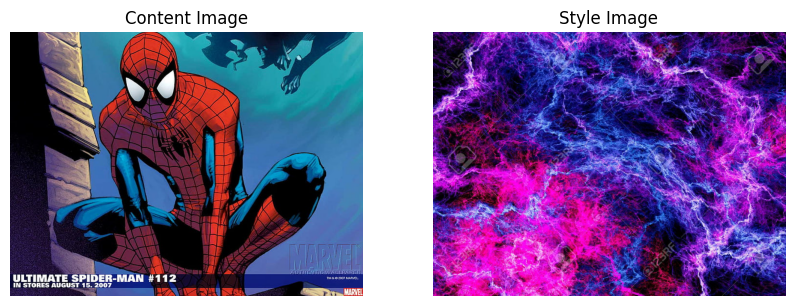

In [20]:

content_img_path = '/content/drive/MyDrive/Assignment/content.jpg'
style_img_path = '/content/drive/MyDrive/Assignment/style.jpg'
content_img = cv.imread(content_img_path)
style_img = cv.imread(style_img_path)

# Convert images from BGR to RGB
content_img_rgb = cv.cvtColor(content_img, cv.COLOR_BGR2RGB)
style_img_rgb = cv.cvtColor(style_img, cv.COLOR_BGR2RGB)

# Plotting side by side
plt.figure(figsize=(10, 5))

# Plot content image
plt.subplot(1, 2, 1)
plt.imshow(content_img_rgb)
plt.title('Content Image')
plt.axis('off')

# Plot style image
plt.subplot(1, 2, 2)
plt.imshow(style_img_rgb)
plt.title('Style Image')
plt.axis('off')

# Show the plot
plt.show()

In [21]:
target_shape = 400
current_dir = os.getcwd()
default_resource_dir = os.path.join(current_dir, 'data')
model_dir = os.path.join(default_resource_dir, 'Saved Model')
config = {
    'height': target_shape,
    'content_weight': 1,
    'style_weight': .5,
    'tv_weight': 1e-3,
    'optimizer': 'lbfgs',
    'content_img_path': content_img_path,
    'style_img_path': style_img_path,
    'output_img_dir': default_resource_dir,
    'img_format': (3,'.jpg')
}
results_path = neural_style_transfer(config, model_dir)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:04<00:00, 124MB/s]


L-BFGS | iteration: 000, total loss=63502524.0000, content_loss=      0.0000, style loss=63488736.0000, tv loss=  13786.1210
L-BFGS | iteration: 001, total loss=63502492.0000, content_loss=      0.0000, style loss=63488704.0000, tv loss=  13786.1210
L-BFGS | iteration: 002, total loss=63502300.0000, content_loss=      0.0000, style loss=63488512.0000, tv loss=  13786.1240
L-BFGS | iteration: 003, total loss=63502024.0000, content_loss=      0.0000, style loss=63488236.0000, tv loss=  13786.1280
L-BFGS | iteration: 004, total loss=63499768.0000, content_loss=      0.0001, style loss=63485980.0000, tv loss=  13786.1600
L-BFGS | iteration: 005, total loss=63487312.0000, content_loss=      0.0015, style loss=63473524.0000, tv loss=  13786.3330
L-BFGS | iteration: 006, total loss=63350856.0000, content_loss=      0.1548, style loss=63337068.0000, tv loss=  13788.2480
L-BFGS | iteration: 007, total loss=62679636.0000, content_loss=      4.6485, style loss=62665836.0000, tv loss=  13797.8280


### Styled Image



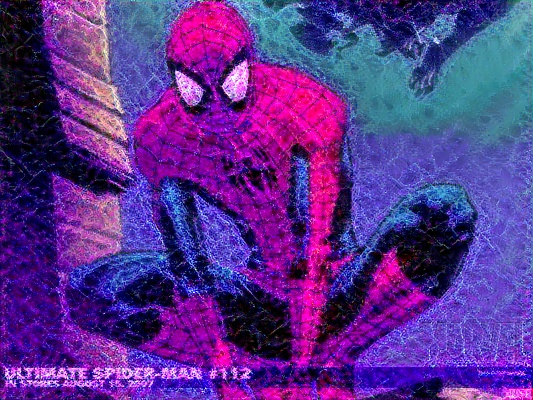